In [57]:
import os

In [58]:
os.environ["LANGCHAIN_API_KEYS"]="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"
os.environ["TAVILY_API_KEY"]="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"
os.environ["GROQ_API_KEY"]="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"

In [59]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [60]:
import operator
from typing import Annotated,Sequence,Literal
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage,HumanMessage,ToolMessage,AIMessage
from langgraph.graph import StateGraph,END
from langgraph.prebuilt import ToolNode
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
import functools
from langchain_experimental.agents import create_csv_agent
from tavily import TavilyClient

In [61]:
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [62]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

In [63]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [64]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama3-70b-8192",temperature= 0.3)

In [65]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
@tool
def wikipedia_tool(input: Annotated[str,"The query which is passed to search in wikipedia"],):
    """Use this tool when the user need a short description about any topic.
    """
    api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=100)
    wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)
    return wiki_tool.run(input)+ "\n\nIf you have completed all tasks, respond with FINAL ANSWER."

In [66]:
@tool
def Tavily_tool(input: Annotated[str,"The query which is passed to search in internet using tavil tool"],):
    """use this tool only when the user tells to search from internet or from websites.
    """
    tavily = TavilyClient(api_key="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")
    query = input
    response = tavily.search(query)
    if response["results"][0]:
        result=response["results"][0]
        return(result.get("content"))+ "\n\nIf you have completed all tasks, respond with FINAL ANSWER."

In [67]:
@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your output."],):
    """Use this to execute python code. If you want to see the output,
    you should print it out with `print(...)` or you could also use pandas,matplotib,numpy. This is visible to the user.
    """
    try:
        repl = PythonREPL()
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str+ "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [68]:
tools=[Tavily_tool,python_repl,wikipedia_tool]
tool_node = ToolNode(tools)

In [69]:
research_agent = create_agent(
    llm,
    [Tavily_tool,wikipedia_tool],
    system_message="You should provide data in text format.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")


In [70]:
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Get the data from user or Researcher agent and generate desired charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

In [71]:
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    return "continue"

In [72]:
workflow = StateGraph(State)

workflow.add_node("Researcher", research_node)
workflow.add_node("Performer", chart_node)
workflow.add_node("call_tool", tool_node)



workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "Performer","call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "Performer",
    router,
    {"continue": "Researcher","call_tool": "call_tool", "__end__": END},
)


workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "Performer": "Performer",
    },
)




workflow.set_entry_point("Researcher")
graph = workflow.compile()

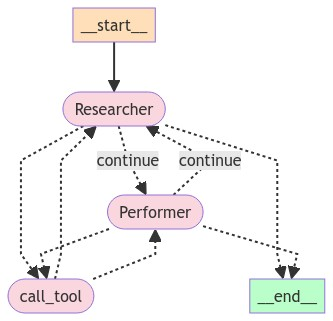

In [73]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [56]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="""Collect the gdp of 5 nations and save it as csv file as GDP.csv"""
            )
        ],
    },
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_n2eg', 'function': {'arguments': '{"input":"GDP of 5 nations"}', 'name': 'Tavily_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 1143, 'total_tokens': 1193, 'completion_time': 0.142857143, 'prompt_time': 0.643746143, 'queue_time': None, 'total_time': 0.786603286}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_7ab5f7e105', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-4c2a06f6-6823-4701-a95b-652c0aeb2e17-0', tool_calls=[{'name': 'Tavily_tool', 'args': {'input': 'GDP of 5 nations'}, 'id': 'call_n2eg'}])], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='Table\nThe table initially ranks each country or territory with their latest available estimates, and can be reranked by either of the sources\nThe links in the "Country/Territory" row of the following table li

Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mdkj', 'function': {'arguments': '{"code":"import csv\\nwith open(\'GDP.csv\', \'w\', newline=\'\') as file:\\n    writer = csv.writer(file)\\n    writer.writerow([\\"Country\\", \\"GDP (nominal)\\"])\\n    writer.writerow([\\"United States\\", \\"22.67 trillion\\"])\\n    writer.writerow([\\"China\\", \\"16.14 trillion\\"])\\n    writer.writerow([\\"Japan\\", \\"5.15 trillion\\"])\\n    writer.writerow([\\"Germany\\", \\"4.24 trillion\\"])\\n    writer.writerow([\\"United Kingdom\\", \\"2.62 trillion\\"])"}', 'name': 'python_repl'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 153, 'prompt_tokens': 2036, 'total_tokens': 2189, 'completion_time': 0.437142857, 'prompt_time': 0.907796305, 'queue_time': None, 'total_time': 1.344939162}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2f30b0b571', 'finish_reason': 'tool_calls', 'logprobs': None}